In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.pipeline import make_pipeline, Pipeline
from imblearn.under_sampling import RandomUnderSampler

import imblearn
from imblearn.over_sampling import SMOTE
from collections import Counter
from numpy import where

In [2]:
df = pd.read_csv('ccdefault.csv', sep = ',')
df.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,DEFAULT
0,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


# Identify X and y

In [3]:
X = df.iloc[:, 1:-1].values
y = df.iloc[:, -1].values

# Train_test_split

In [4]:
X_train,X_test,y_train,y_test=train_test_split(X, y, test_size=0.1, stratify=y, random_state=1)
print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(27000, 23) (3000, 23)
(27000,) (3000,)


# Baseline model

In [5]:
tree = DecisionTreeClassifier()
tree.fit(X_train, y_train)
y_pred = tree.predict(X_test)
print('Test Accuracy: %.3f' % tree.score(X_test, y_test))

Test Accuracy: 0.727


In [6]:
# define model
model = DecisionTreeClassifier()
# evaluate pipeline
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
scores = cross_val_score(model, X_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1)
print('Test Accuracy: %.3f' % np.mean(scores))

Test Accuracy: 0.724


# Decision tree classifier

In [7]:
# Using a for loop to test multiple values of random_state for DecisionTree Classifier.
# try random_state from 1 to 10 and record test accuracy score

train_score = []
test_score = []

for i in range(1,11):
    tree = DecisionTreeClassifier(max_depth=3, criterion='gini', max_features=5, random_state = i)
    tree.fit(X_train, y_train)
    y_pred = tree.predict(X_test)
    train_score.append(accuracy_score(y_train, tree.predict(X_train)))  
    test_score.append(accuracy_score(y_test, y_pred))

In [8]:
print('The accuracy score for the train set is ', np.round(train_score, 3))
print('The accuracy score for the test set is ', np.round(test_score, 3))

The accuracy score for the train set is  [0.799 0.82  0.796 0.821 0.82  0.82  0.819 0.8   0.82  0.817]
The accuracy score for the test set is  [0.804 0.825 0.8   0.821 0.822 0.82  0.82  0.806 0.819 0.821]


In [9]:
print('The mean of accuracy score for the train set is ', np.round(np.mean(train_score), 3))
print('The standard deviation of accuracy score for the train set is ', np.round(np.std(train_score), 3))
print('The mean of accuracy score for the test set is ', np.round(np.mean(test_score), 3))
print('The standard deviation of accuracy score for the test set is ', np.round(np.std(test_score), 3))

The mean of accuracy score for the train set is  0.813
The standard deviation of accuracy score for the train set is  0.01
The mean of accuracy score for the test set is  0.816
The standard deviation of accuracy score for the test set is  0.008


In [10]:
# Confusion Matrix
conmatrix = confusion_matrix(y_test, y_pred)
conmatrix_df = pd.DataFrame(conmatrix, 
              columns = ['pred_class 0 ', 'pred_class 1'], 
              index = ['actual_class 0', 'actual_class 1']
              )
print(conmatrix_df)

# this is an imbalance data

                pred_class 0   pred_class 1
actual_class 0           2185           151
actual_class 1            387           277


In [11]:
# Classification Report
target = ['class 0 (non-defaults)','class 1 (defaults)']
report = classification_report(y_test, y_pred, target_names = target)
print(report)

                        precision    recall  f1-score   support

class 0 (non-defaults)       0.85      0.94      0.89      2336
    class 1 (defaults)       0.65      0.42      0.51       664

              accuracy                           0.82      3000
             macro avg       0.75      0.68      0.70      3000
          weighted avg       0.80      0.82      0.81      3000



<ipython-input-12-b40b312ef472>:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + labels)
<ipython-input-12-b40b312ef472>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + labels)


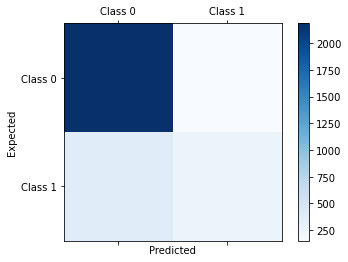

In [12]:
labels = ['Class 0', 'Class 1']
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion_matrix(y_test, y_pred), cmap=plt.cm.Blues)
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('Expected')
plt.show()

# Tuning hyperparameters via grid search with imbalanced dataset

In [13]:
# Using grid search cross validation to select the best parameters

param_grid = {'max_depth':list(range(1, 10)),
              'max_features': list(range(1, 10)),
             'criterion': ["gini", "entropy"]}

tree_cv = GridSearchCV(DecisionTreeClassifier(random_state=43), param_grid, scoring = 'accuracy', cv = 10, n_jobs = -1)
tree_cv.fit(X_train, y_train)


print("Tuned Decision Tree Parameters: {}".format(tree_cv.best_params_))
print("Best training accuracy score using cv is {}".format(np.round(tree_cv.best_score_, 3)))

Tuned Decision Tree Parameters: {'criterion': 'entropy', 'max_depth': 4, 'max_features': 7}
Best training accuracy score using cv is 0.821


In [14]:
# Cross val score
train_cv_scores = cross_val_score(tree_cv, X_train, y_train, scoring = 'accuracy', cv=10, n_jobs=-1)
test_cv_scores = cross_val_score(tree_cv, X_test, y_test, scoring = 'accuracy', cv=10, n_jobs=-1)

In [15]:
print('The CV accuracy scores for the train set is: %s' % np.round(train_cv_scores, 3))
print('The mean/standard deviation of CV accuracy score for the train set is: %.3f +/- %.3f' % (np.mean(train_cv_scores), np.std(train_cv_scores)))
print('The CV accuracy scores for the test set is: %s' % np.round(test_cv_scores, 3))
print('The mean/standard deviation of CV accuracy score for the test set is: %.3f +/- %.3f' % (np.mean(test_cv_scores), np.std(test_cv_scores)))

The CV accuracy scores for the train set is: [0.815 0.82  0.815 0.813 0.822 0.813 0.82  0.823 0.823 0.827]
The mean/standard deviation of CV accuracy score for the train set is: 0.819 +/- 0.005
The CV accuracy scores for the test set is: [0.817 0.84  0.837 0.827 0.797 0.84  0.827 0.79  0.82  0.787]
The mean/standard deviation of CV accuracy score for the test set is: 0.818 +/- 0.019


In [16]:
## Using the best parameters to build decision tree model
tree = DecisionTreeClassifier(criterion='entropy', max_depth = 4, max_features=7, random_state=43)
tree.fit(X_train, y_train)
y_pred = tree.predict(X_test)
tree_bestcv_score = accuracy_score(y_test, y_pred)
print('The testing accuracy score using the best parameters is {}'.format(np.round(tree_bestcv_score, 3)))

The testing accuracy score using the best parameters is 0.823


In [17]:
# Confusion Matrix
conmatrix = confusion_matrix(y_test, y_pred)
conmatrix = pd.DataFrame(conmatrix, 
              columns = ['pred_class 0 ', 'pred_class 1'], 
              index = ['actual_class 0', 'actual_class 1']
              )
print(conmatrix)

                pred_class 0   pred_class 1
actual_class 0           2236           100
actual_class 1            430           234


In [18]:
# Classification Report
target = ['class 0 (non-defaults)','class 1 (defaults)']
report = classification_report(y_test, y_pred, target_names = target)
print(report)

                        precision    recall  f1-score   support

class 0 (non-defaults)       0.84      0.96      0.89      2336
    class 1 (defaults)       0.70      0.35      0.47       664

              accuracy                           0.82      3000
             macro avg       0.77      0.65      0.68      3000
          weighted avg       0.81      0.82      0.80      3000



# SMOTE for Imbalancing Data

In [19]:
!pip install -U imbalanced-learn

In [20]:
conda install -c glemaitre imbalanced-learn

Solving environment: ...working... done

# All requested packages already installed.


Note: you may need to restart the kernel to use updated packages.


In [21]:
# summarize class distribution
counter = Counter(y_train)
print(counter)

Counter({0: 21028, 1: 5972})


In [22]:
# transform the dataset
oversample = SMOTE(random_state=12)
X_train_SMOTE, y_train_SMOTE = oversample.fit_resample(X_train, y_train)
X_test_SMOTE, y_test_SMOTE = oversample.fit_resample(X_test, y_test)

In [23]:
# summarize the new class distribution
counter_SMOTE = Counter(y_train_SMOTE)
print(counter_SMOTE)

Counter({1: 21028, 0: 21028})


# Tuning hyperparameters via grid search after SMOTE

In [24]:
# Using grid search cross validation to select the best parameters

param_grid = {'max_depth':list(range(1, 10)),
              'max_features': list(range(1, 10)),
             'criterion': ["gini", "entropy"]}

tree_cv = GridSearchCV(DecisionTreeClassifier(random_state=43), param_grid, scoring = 'accuracy', cv = 10, n_jobs = -1)
tree_cv.fit(X_train_SMOTE, y_train_SMOTE)


print("Tuned Decision Tree Parameters: {}".format(tree_cv.best_params_))
print("Best training accuracy score using cv is {}".format(np.round(tree_cv.best_score_, 3)))

Tuned Decision Tree Parameters: {'criterion': 'gini', 'max_depth': 9, 'max_features': 8}
Best training accuracy score using cv is 0.749


In [25]:
# Cross val score
train_cv_SMOTE_scores = cross_val_score(tree_cv, X_train_SMOTE, y_train_SMOTE, scoring = 'accuracy', cv=10, n_jobs=-1)
test_cv_SMOTE_scores = cross_val_score(tree_cv, X_test_SMOTE, y_test_SMOTE, scoring = 'accuracy', cv=10, n_jobs=-1)

In [26]:
print('The CV accuracy scores for the train set after SMOTE is: %s' % np.round(train_cv_SMOTE_scores, 3))
print('The mean/standard deviation of CV accuracy score for the train set after SMOTE is: %.3f +/- %.3f' % (np.mean(train_cv_SMOTE_scores), np.std(train_cv_SMOTE_scores)))
print('The CV accuracy scores for the test set after SMOTE is: %s' % np.round(test_cv_SMOTE_scores, 3))
print('The mean/standard deviation of CV accuracy score for the test set after SMOTE is: %.3f +/- %.3f' % (np.mean(test_cv_SMOTE_scores), np.std(test_cv_SMOTE_scores)))

The CV accuracy scores for the train set after SMOTE is: [0.672 0.659 0.688 0.778 0.778 0.778 0.766 0.787 0.768 0.78 ]
The mean/standard deviation of CV accuracy score for the train set after SMOTE is: 0.745 +/- 0.048
The CV accuracy scores for the test set after SMOTE is: [0.673 0.671 0.722 0.782 0.767 0.769 0.788 0.728 0.767 0.786]
The mean/standard deviation of CV accuracy score for the test set after SMOTE is: 0.745 +/- 0.042


In [27]:
## Using the best parameters to build decision tree model
tree = DecisionTreeClassifier(criterion='gini', max_depth = 9, max_features=8, random_state=43)
tree.fit(X_train_SMOTE, y_train_SMOTE)
y_pred_SMOTE = tree.predict(X_test_SMOTE)
tree_bestSMOTEcv_score = accuracy_score(y_test_SMOTE, y_pred_SMOTE)
print('The testing accuracy score using the best parameters is {}'.format(np.round(tree_bestSMOTEcv_score, 3)))

The testing accuracy score using the best parameters is 0.743


In [28]:
# Confusion Matrix
conmatrix_SMOTE = confusion_matrix(y_test_SMOTE, y_pred_SMOTE)
conmatrix_SMOTE = pd.DataFrame(conmatrix_SMOTE, 
              columns = ['pred_class 0 ', 'pred_class 1'], 
              index = ['actual_class 0', 'actual_class 1']
              )
print(conmatrix_SMOTE)

                pred_class 0   pred_class 1
actual_class 0           1825           511
actual_class 1            689          1647


In [29]:
# Classification Report
target = ['class 0 (non-defaults)','class 1 (defaults)']
report_SMOTE = classification_report(y_test_SMOTE, y_pred_SMOTE, target_names = target)
print(report_SMOTE)

                        precision    recall  f1-score   support

class 0 (non-defaults)       0.73      0.78      0.75      2336
    class 1 (defaults)       0.76      0.71      0.73      2336

              accuracy                           0.74      4672
             macro avg       0.74      0.74      0.74      4672
          weighted avg       0.74      0.74      0.74      4672



<ipython-input-30-6f20c28436eb>:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + labels)
<ipython-input-30-6f20c28436eb>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + labels)


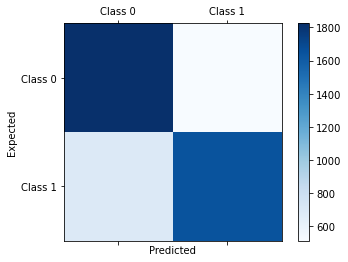

In [30]:
labels = ['Class 0', 'Class 1']
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion_matrix(y_test_SMOTE, y_pred_SMOTE), cmap=plt.cm.Blues)
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('Expected')
plt.show()

# Randomundersampling for Imbalancing Data

In [31]:
# transform the dataset
undersample = RandomUnderSampler(random_state=12)
X_train_undersample, y_train_undersample = oversample.fit_resample(X_train, y_train)
X_test_undersample, y_test_undersample = oversample.fit_resample(X_test, y_test)

In [33]:
print(X_train_undersample.shape, y_train_undersample.shape)

(42056, 23) (42056,)


In [34]:
# summarize the new class distribution
counter_undersample = Counter(y_train_undersample)
print(counter_undersample)

Counter({1: 21028, 0: 21028})


# Tuning hyperparameters via grid search after Randomundersampling

In [35]:
# Using grid search cross validation to select the best parameters

param_grid = {'max_depth':list(range(1, 10)),
              'max_features': list(range(1, 10)),
             'criterion': ["gini", "entropy"]}

tree_cv_2 = GridSearchCV(DecisionTreeClassifier(random_state=43), param_grid, scoring = 'accuracy', cv = 10, n_jobs = -1)
tree_cv_2.fit(X_train_undersample, y_train_undersample)


print("Tuned Decision Tree Parameters: {}".format(tree_cv_2.best_params_))
print("Best training accuracy score using cv is {}".format(np.round(tree_cv_2.best_score_, 3)))

Tuned Decision Tree Parameters: {'criterion': 'gini', 'max_depth': 9, 'max_features': 8}
Best training accuracy score using cv is 0.749


In [36]:
# Cross val score
train_cv_undersample_scores = cross_val_score(tree_cv_2, X_train_undersample, y_train_undersample, scoring = 'accuracy', cv=10, n_jobs=-1)
test_cv_undersample_scores = cross_val_score(tree_cv_2, X_test_undersample, y_test_undersample, scoring = 'accuracy', cv=10, n_jobs=-1)

In [37]:
print('The CV accuracy scores for the train set after Randomundersampling is: %s' % np.round(train_cv_undersample_scores, 3))
print('The mean/standard deviation of CV accuracy score for the train set after Randomundersampling is: %.3f +/- %.3f' % (np.mean(train_cv_undersample_scores), np.std(train_cv_undersample_scores)))
print('The CV accuracy scores for the test set after Randomundersampling is: %s' % np.round(test_cv_undersample_scores, 3))
print('The mean/standard deviation of CV accuracy score for the test set after Randomundersampling is: %.3f +/- %.3f' % (np.mean(test_cv_undersample_scores), np.std(test_cv_undersample_scores)))

The CV accuracy scores for the train set after Randomundersampling is: [0.672 0.659 0.688 0.778 0.778 0.778 0.766 0.787 0.768 0.78 ]
The mean/standard deviation of CV accuracy score for the train set after Randomundersampling is: 0.745 +/- 0.048
The CV accuracy scores for the test set after Randomundersampling is: [0.673 0.671 0.722 0.782 0.767 0.769 0.788 0.728 0.767 0.786]
The mean/standard deviation of CV accuracy score for the test set after Randomundersampling is: 0.745 +/- 0.042


In [38]:
## Using the best parameters to build decision tree model
tree = DecisionTreeClassifier(criterion='gini', max_depth = 9, max_features=8, random_state=43)
tree.fit(X_train_undersample, y_train_undersample)
y_pred_undersample = tree.predict(X_test_undersample)
tree_bestUndersamplecv_score = accuracy_score(y_test_undersample, y_pred_undersample)
print('The testing accuracy score using the best parameters is {}'.format(np.round(tree_bestUndersamplecv_score, 3)))

The testing accuracy score using the best parameters is 0.743


In [39]:
# Confusion Matrix
conmatrix_undersample = confusion_matrix(y_test_undersample, y_pred_undersample)
conmatrix_undersample = pd.DataFrame(conmatrix_undersample, 
              columns = ['pred_class 0 ', 'pred_class 1'], 
              index = ['actual_class 0', 'actual_class 1']
              )
print(conmatrix_undersample)

                pred_class 0   pred_class 1
actual_class 0           1825           511
actual_class 1            689          1647


In [40]:
# Classification Report
target = ['class 0 (non-defaults)','class 1 (defaults)']
report_undersample = classification_report(y_test_undersample, y_pred_undersample, target_names = target)
print(report_undersample)

                        precision    recall  f1-score   support

class 0 (non-defaults)       0.73      0.78      0.75      2336
    class 1 (defaults)       0.76      0.71      0.73      2336

              accuracy                           0.74      4672
             macro avg       0.74      0.74      0.74      4672
          weighted avg       0.74      0.74      0.74      4672



<ipython-input-41-4cb39ff9d4b9>:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + labels)
<ipython-input-41-4cb39ff9d4b9>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + labels)


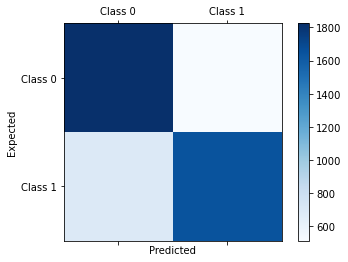

In [41]:
labels = ['Class 0', 'Class 1']
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion_matrix(y_test_undersample, y_pred_undersample), cmap=plt.cm.Blues)
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('Expected')
plt.show()

In [42]:
print("My name is Hui-Erh Chai_Angela")
print("My NetID is: 674939884")
print("I hereby certify that I have read the University policy on Academic Integrity and that I am not in violation.")

My name is Hui-Erh Chai_Angela
My NetID is: 674939884
I hereby certify that I have read the University policy on Academic Integrity and that I am not in violation.
